In [1]:
import numpy as np
import sys
import os
# sys.path.append('.conda/envs/shear/lib/python3.9/site-packages/')
import astropy.io.fits as pf
import matplotlib.pylab as mplot
%pylab inline
import fitsio
import h5py

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
metadata = np.genfromtxt('../Tilelist_DR3_1_1.csv', dtype='str', delimiter=",")[1:]
# print(metadata)

In [3]:
Columns = ['dec', 'good_frac', 'id', 
           'mcal_T_1m', 'mcal_T_1p', 'mcal_T_2m', 'mcal_T_2p', 'mcal_T_err_1m',
           'mcal_T_err_1p', 'mcal_T_err_2m', 'mcal_T_err_2p', 'mcal_T_err_noshear',
           'mcal_T_noshear', 'mcal_T_ratio_1m', 'mcal_T_ratio_1p', 'mcal_T_ratio_2m',
           'mcal_T_ratio_2p', 'mcal_T_ratio_noshear', 'mcal_flags', 'mcal_flux_1m', 'mcal_flux_1p',
           'mcal_flux_2m', 'mcal_flux_2p', 'mcal_flux_cov_1m', 'mcal_flux_cov_1p', 'mcal_flux_cov_2m',
           'mcal_flux_cov_2p', 'mcal_flux_cov_noshear', 'mcal_flux_err_1m', 'mcal_flux_err_1p',
           'mcal_flux_err_2m', 'mcal_flux_err_2p', 'mcal_flux_err_noshear', 'mcal_flux_noshear',
           'mcal_g_1m', 'mcal_g_1p', 'mcal_g_2m', 'mcal_g_2p', 'mcal_g_cov_1m', 'mcal_g_cov_1p',
           'mcal_g_cov_2m', 'mcal_g_cov_2p', 'mcal_g_cov_noshear', 'mcal_g_noshear', 'mcal_nfev_1m',
           'mcal_nfev_1p', 'mcal_nfev_2m', 'mcal_nfev_2p', 'mcal_nfev_noshear', 'mcal_pars_1m',
           'mcal_pars_1p', 'mcal_pars_2m', 'mcal_pars_2p', 'mcal_pars_cov_1m', 'mcal_pars_cov_1p',
           'mcal_pars_cov_2m', 'mcal_pars_cov_2p', 'mcal_pars_cov_noshear', 'mcal_pars_noshear',
           'mcal_psf_T_noshear', 'mcal_psf_g_noshear', 'mcal_s2n_1m', 'mcal_s2n_1p', 'mcal_s2n_2m',
           'mcal_s2n_2p', 'mcal_s2n_noshear', 'mcal_s2n_r_1m', 'mcal_s2n_r_1p', 'mcal_s2n_r_2m',
           'mcal_s2n_r_2p', 'mcal_s2n_r_noshear', 'ra', 'x', 'y']


# Columns = ['mcal_s2n_r_2p']


shear_dir = '/project/chihway/data/decade/shearcat_v2/'
coadd_dir = '/project/chihway/data/decade/coaddcat_v2/'

path = '/scratch/midway3/chihway/metacal_test_20230320.hdf'

with h5py.File(path, "w") as f:

    #Create all columns you need
    test_tile = metadata[1][0]
    test_fits = fitsio.FITS(shear_dir+'metacal_output_'+test_tile+'.fits')
    
    for col in Columns:
        if col!='ra' and col!='dec':
            Ndim = len(test_fits[1].read(vstorage='object')[col].shape)
            if Ndim==1:
                type_col = str(type(test_fits[1].read(vstorage='object')[col][0])).replace('class', '').replace("< '", "").replace("'>", "").replace("numpy.", "")
                f.create_dataset(col, data = [], chunks=(10**4,), maxshape = (None,), dtype=type_col)
            if Ndim==2:
                type_col = str(type(test_fits[1].read(vstorage='object')[col][0][0])).replace('class', '').replace("< '", "").replace("'>", "").replace("numpy.", "")
                f.create_dataset(col, data = [[]], chunks=((10**4,10)), maxshape = (None,10), dtype=type_col)
            if Ndim==3:
                type_col = str(type(test_fits[1].read(vstorage='object')[col][0][0][0])).replace('class', '').replace("< '", "").replace("'>", "").replace("numpy.", "")
                f.create_dataset(col, data = [[[]]], chunks=((10**4,10,10)), maxshape = (None,10,10), dtype=type_col)

    f.create_dataset('ra', data = [], chunks=(10**4,), maxshape = (None,))            
    f.create_dataset('dec', data = [], chunks=(10**4,), maxshape = (None,))            

    # Appends new_data array into existing dataset
    def add_data(dataset, new_data):

        if len(new_data.shape)==1:
            dataset.resize(dataset.shape[0] + len(new_data), axis=0)
            dataset[-len(new_data):] = new_data

        if len(new_data.shape)==2:
            dataset.resize((dataset.shape[0] + len(new_data),new_data.shape[1]))
            dataset[-len(new_data):] = new_data

        if len(new_data.shape)==3:
            dataset.resize((dataset.shape[0] + len(new_data),new_data.shape[1],new_data.shape[2]))
            dataset[-len(new_data):] = new_data


    for i in range(100):
        tile = metadata[i][0]
        print(tile)

        if os.path.exists(shear_dir+'metacal_output_'+tile+'.fits') and os.path.exists(coadd_dir+'gold_mask_'+tile+'.npz'):
            fits = fitsio.FITS(shear_dir+'metacal_output_'+tile+'.fits')
 
            shear_cat = fits[1].read(vstorage='object')
            # metacal output files, it has an ID that is the correct coadd IDs, but already 
            # with a cut that only includes objects that have a metacal measurement

            shear_id = np.load(shear_dir+'ids_match_'+tile+'.npz', allow_pickle=True)
            # ad hoc file we save when running metacal, the full list of coadd IDs for all objects in the MEDS file
            # these are row-by-row matched to the catalog files that contain e.g. photometry

            gold_mask = np.load(coadd_dir+'gold_mask_'+tile+'.npz', allow_pickle=True)
            gold_mask_full = gold_mask['maskSE']*gold_mask['maskIMA']*(gold_mask['maskSG']>=2) 
            # from the catalog files, we make the gold cut
            # still using rough star/galaxy separation

            shear_id_masked_gold = shear_id['ids'][gold_mask_full]
            # this is IDs of all the objects that pass the gold cut

            mask_joint = np.in1d(shear_cat['id'], shear_id_masked_gold)
            # mask to apply on the metacal catalog, to remove objects that don't pass the gold cut

            mask_joint_invert = np.in1d(shear_id_masked_gold, shear_cat['id'][mask_joint])
            # invert mask to apply to the original tile catalog, to selecout the final objects

            ra = gold_mask['ra'][gold_mask_full][mask_joint_invert]
            dec = gold_mask['dec'][gold_mask_full][mask_joint_invert]
            add_data(f['ra'], ra)
            add_data(f['dec'], dec)
            
            for col2 in Columns:
                if col2!='ra' and col2!='dec':
                    data2 = shear_cat[col2][mask_joint]
                    add_data(f[col2], data2)
                    if col2=='id':
                        print(i, len(f[col2]))

        else:
            print('tile missing '+tile)



DES0934-0207
tile missing DES0934-0207
DES1011-0915
1 17720
DES1006-1915
2 32258
DES0845+0209
3 50320
DES1157-1124
4 71452
DES1143-0958
5 95265
DES0756+2625
6 111169
DES0700+2834
7 121605
DES0936-0624
8 140321
DES0849+2500
9 158301
DES1111+2917
10 173441
DES1017-0207
11 204216
DES0856+1209
12 221579
DES1010+0043
13 246518
DES0910+0626
14 262814
DES1026-2124
15 279456
DES0901+1500
16 298443
DES0938-1041
17 314752
DES1122-1915
18 333844
DES0810+0917
19 351301
DES1040-1707
20 370042
DES1051+0500
21 383939
DES0948+2043
22 402200
DES1047-1458
23 422891
DES1047+1417
24 433755
DES1015+0335
25 454049
DES0824-0416
26 467619
DES0831+1626
27 484542
DES1016-2124
28 501665
DES0918+1000
29 519109
DES1053-1041
30 542681
DES0910-1707
31 555959
DES1037-0458
32 573761
DES0949+0335
33 588642
DES0851+1126
34 611158
DES0747+1126
35 630277
DES0804-0915
36 643511
DES0920+2334
37 657351
DES0942+1626
38 670594
DES0705+2500
39 685119
DES0653+2251
40 690613
DES1014-1458
41 709976
DES1113-1415
42 728779
DES1116+1

In [ ]:
with h5py.File('/scratch/midway3/chihway/metacal_test_20230320.hdf', 'r') as f:
    for tag in Columns:
        print(tag, f[tag][:])
#     print(f['mcal_s2n_r_1m'][10000:])

dec [-9.62664418 -9.62669539 -9.62664437 ... 26.77570135 26.77766688
 26.77954955]
good_frac [0. 0. 0. ... 0. 0. 0.]
id [7109349448 7109349445 7109349444 ... 6994186260 6994186255 6994186252]
mcal_T_1m [0.69624508 0.02310825 1.05558625 ... 0.37144232 0.36860292 0.23766639]
mcal_T_1p [0.86718231 0.01892702 1.09171683 ... 0.36299647 0.36585964 0.24095162]
mcal_T_2m [0.79075157 0.02108396 1.07141792 ... 0.35988496 0.3618491  0.24525648]
mcal_T_2p [0.79767947 0.01925319 1.08533291 ... 0.37478672 0.36964017 0.23788841]
mcal_T_err_1m [0.12008654 0.01614882 0.14124951 ... 0.01569306 0.0579613  0.03674691]
mcal_T_err_1p [0.14248263 0.01606691 0.14560352 ... 0.01542585 0.05651823 0.03661294]
mcal_T_err_2m [0.13138039 0.01619048 0.14379151 ... 0.01553504 0.05686607 0.03669111]
mcal_T_err_2p [0.13294668 0.01597537 0.14454543 ... 0.01555418 0.05793563 0.03639487]
mcal_T_err_noshear [0.14504437 0.01612335 0.1445293  ... 0.01560594 0.05724247 0.03670241]
mcal_T_noshear [0.88938798 0.02188079 1.07576

mcal_flux_noshear [[   0.            0.            0.        ]
 [ 510.89923983 1152.78937132 1104.58531194]
 [1104.36455381 1369.15691529 1526.92519124]
 ...
 [2518.99090184 3582.74166445 4172.76104693]
 [ 569.75193997 1127.66597679 1743.45603433]
 [ 485.76977466  883.02597743 1877.82678767]]
mcal_g_1m [[ 0.          0.        ]
 [ 0.26558847 -0.00742165]
 [ 0.01656633 -0.02430648]
 ...
 [-0.03002739  0.38765038]
 [-0.06006011  0.13212005]
 [-0.04658885 -0.03028604]]
mcal_g_1p [[ 0.          0.        ]
 [ 0.30029748  0.00795431]
 [ 0.02006587 -0.00302009]
 ...
 [-0.01679823  0.38183803]
 [-0.06578582  0.14178347]
 [-0.03434016 -0.02022045]]
mcal_g_2m [[ 0.          0.        ]
 [ 0.2796921  -0.01280809]
 [ 0.02901342 -0.01441269]
 ...
 [-0.019659    0.37800966]
 [-0.06111801  0.13649568]
 [-0.03337306 -0.03202252]]
mcal_g_2p [[ 0.          0.        ]
 [ 0.28994139 -0.00583982]
 [ 0.02252962 -0.00577879]
 ...
 [-0.02720997  0.39132552]
 [-0.04999743  0.14828427]
 [-0.04120018 -0.01199

In [5]:
with h5py.File('/scratch/midway3/chihway/metacal_test_2000tiles_20230214.hdf', 'r') as f:
    print(len(f['ra'][:]))
    ra = f['ra'][:]
    dec = f['dec'][:]
    s2n = f['mcal_s2n_noshear'][:]
    T = f['mcal_T_ratio_noshear'][:]
#     print(len(ra[mask]), len(ra[mask])*1.0/(0.5*60*60*2000))

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/scratch/midway3/chihway/metacal_test_2000tiles_20230214.hdf', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [42]:
mask = (T>0.5)

In [43]:
len(mask)

77156459

In [26]:
import healpy as hp

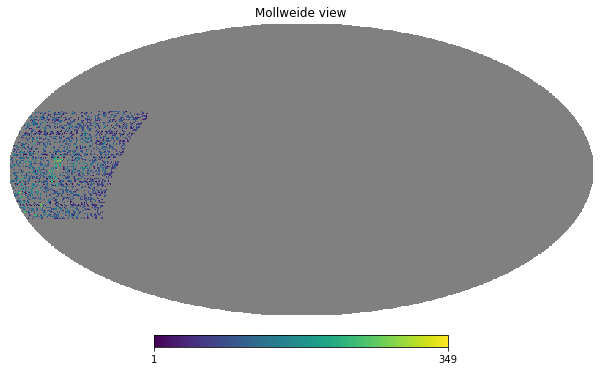

In [27]:
nside = 1024
theta = (90.-dec)/180*np.pi
phi = ra/180*np.pi
pix = hp.ang2pix(nside, theta, phi)
map_shearcat = np.zeros(hp.nside2npix(nside))
for i in range(len(pix)):
    map_shearcat[pix[i]] += 1
    
map_shearcat[map_shearcat==0] = hp.UNSEEN
hp.mollview(map_shearcat)

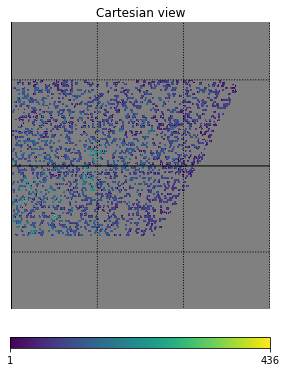

In [28]:
hp.cartview(map_shearcat, lonra=[90,180], latra=[-50,50])
hp.graticule()